In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/reynold/anaconda3/envs/tf10/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the data

In [2]:
orprod_prior = pd.read_csv("data/order_products__prior.csv")
orprod_train = pd.read_csv("data/order_products__train.csv")
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
orders = pd.read_csv("data/orders.csv")
products = pd.read_csv("data/products.csv")

In [3]:
#These files specify which products were purchased in each order. 
#order_products__prior.csv contains previous order contents for all customers. 
#'reordered' indicates that the customer has a previous order that contains the product. 
#Note that some orders will have no reordered items. 
#You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.
orprod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
orprod_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
#This file tells to which set (prior, train, test) an order belongs. 
#You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# Insights

In [9]:
print ("{} unique customers".format(len(orders['user_id'].unique())))

206209 unique customers


## Customer orders

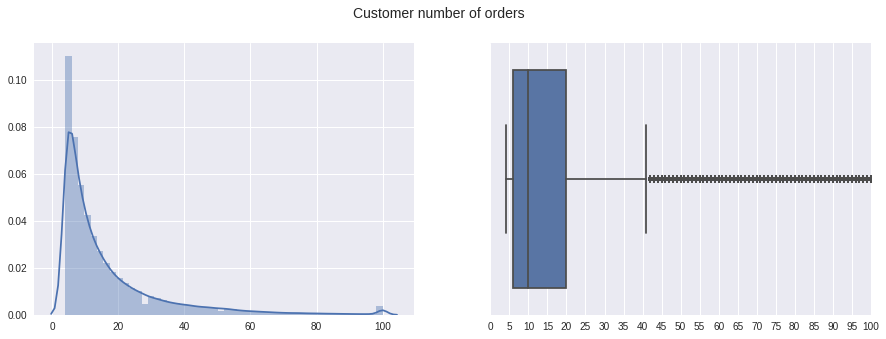

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

user_orders = orders.groupby(['user_id']).size()

plt.figure(figsize=(15,5))
plt.suptitle('Customer number of orders', fontsize=14)
plt.subplot(121)
sns.distplot(user_orders.values)

plt.subplot(122)
sns.boxplot(user_orders.values)
plt.xlim(0,50)
plt.xticks(range(0,105,5))
plt.show()

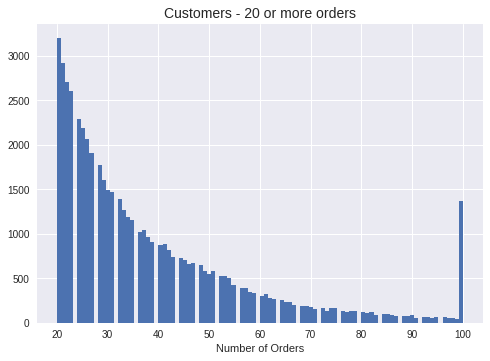

In [11]:
plt.hist(user_orders[user_orders >= 20], bins=100)
plt.title('Customers - 20 or more orders', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

There appears to be a set of hardcore users; it would be interesting to look at their particular buying characteristics

## Orders: day and time

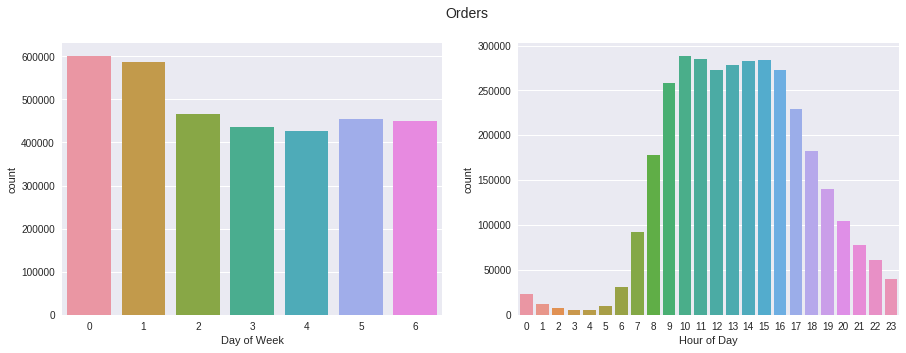

In [12]:
plt.figure(figsize=(15,5))
plt.suptitle('Orders', fontsize=14)
plt.subplot(121)
plt.xlabel('Day of Week')
sns.countplot(orders['order_dow'].values)

plt.subplot(122)
plt.xlabel('Hour of Day')
sns.countplot(orders['order_hour_of_day'].values)
plt.show()

#### alternative method

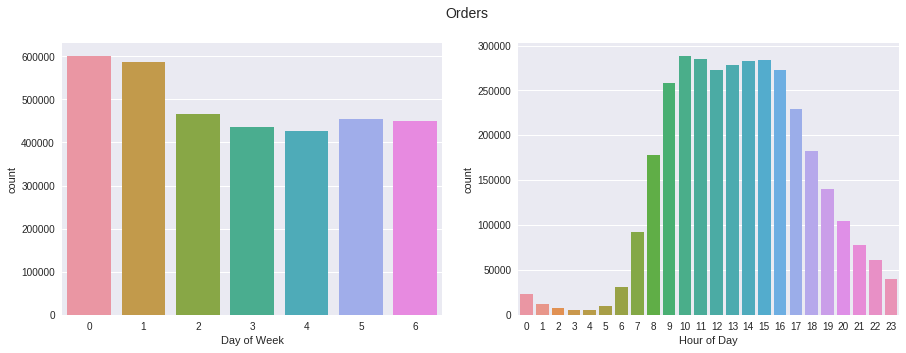

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Orders', fontsize=14)
ax1.set_xlabel('Day of Week')
sns.countplot(orders['order_dow'].values, ax=ax1)

ax2.set_xlabel('Hour of Day')
sns.countplot(orders['order_hour_of_day'].values, ax=ax2)
plt.show()

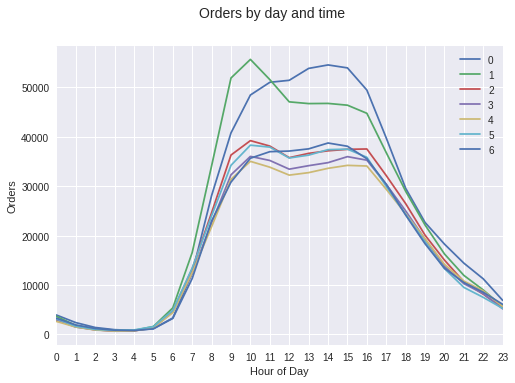

In [18]:
orders_daytime = orders.groupby(['order_dow', 'order_hour_of_day'])['order_dow'].agg(['count']).reset_index()

fig, ax = plt.subplots()
labels = []

for i, group in orders_daytime.groupby('order_dow'):
    ax = group.plot(ax=ax, x='order_hour_of_day', y='count')
    labels.append(i)

lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.suptitle('Orders by day and time', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Orders')
plt.xticks(range(0,24))

plt.show()

Orders peak over two days during the week - afternoon through the next morning

## Days between orders

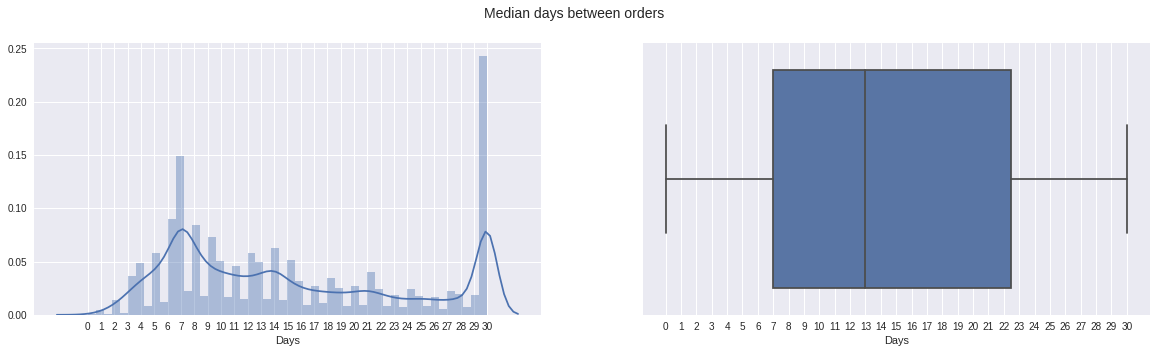

In [19]:
orfreq = orders[orders['days_since_prior_order'].notnull()].groupby(['user_id'])['days_since_prior_order'].agg(['median']).reset_index()

plt.figure(figsize=(20,5))
plt.suptitle('Median days between orders', fontsize=14)
plt.subplot(121)
sns.distplot(orfreq['median'])
plt.xticks(range(0,31,1))
plt.xlabel('Days')

plt.subplot(122)
sns.boxplot(orfreq['median'])
plt.xticks(range(0,31,1))
plt.xlabel('Days')
plt.show()

The most typical median order frequencies are one month or one week; there are bumps at roughly two and three weeks as well

## Number of products ordered

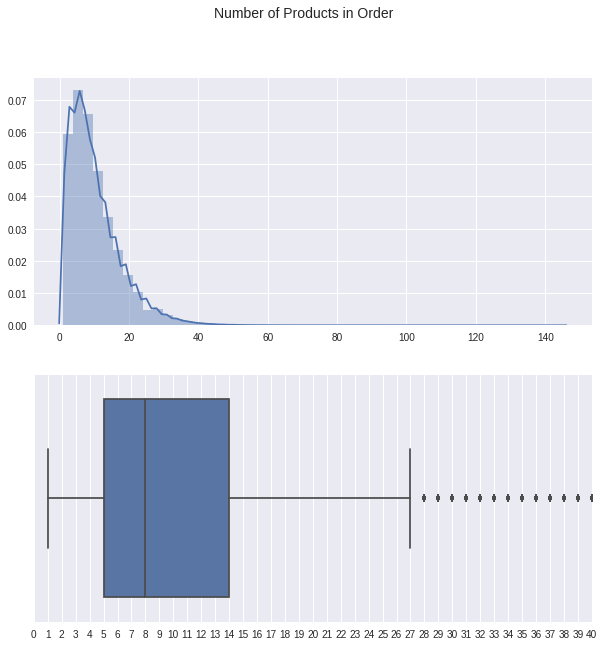

In [20]:
orprod = pd.concat([orprod_prior, orprod_train], ignore_index=True)
num_prods = orprod.groupby(['order_id'])['order_id'].count()

plt.figure(figsize=(10,10))
plt.suptitle('Number of Products in Order', fontsize=14)
plt.subplot(211)
sns.distplot(num_prods.values)

plt.subplot(212)
sns.boxplot(num_prods.values)
plt.xlim(0,40)
plt.xticks(range(0,41,1))
plt.show()

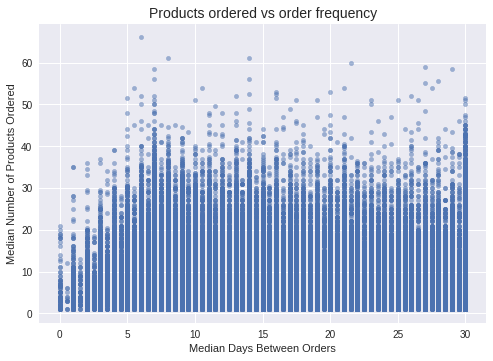

In [21]:
nprods = orprod.groupby(['order_id'])['product_id'].agg(['count']).reset_index().rename(columns={'count':'products'})
nprods = nprods.merge(orders[orders['eval_set'] != 'test'][['order_id', 'user_id']], how='left', on=['order_id']).groupby(['user_id'])['products']\
    .agg(['median']).reset_index().rename(columns={'median': 'median_products'})
user_medians = orfreq.merge(nprods[['user_id', 'median_products']], how='left', on=['user_id'])

user_medians.plot(kind='scatter', y='median_products', x='median', alpha=0.5)
plt.title('Products ordered vs order frequency', fontsize=14)
plt.xlabel('Median Days Between Orders')
plt.ylabel('Median Number of Products Ordered')
plt.show()

No relationship between median number of products a user orders and the median days between orders is seen here

## Top products

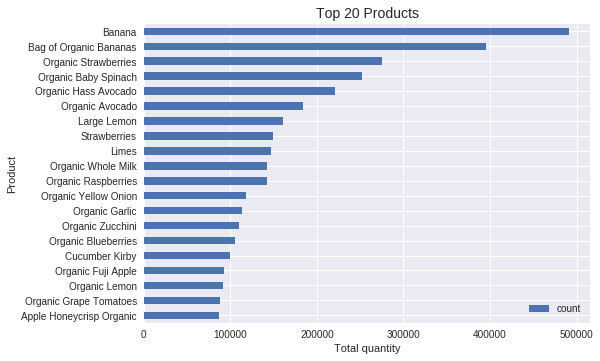

In [22]:
top_prod = orprod.groupby(['product_id'])['product_id'].agg(['count']).sort_values(by='count', ascending=False).reset_index()
top_prod_named = top_prod[:20].merge(products[['product_id', 'product_name', 'department_id']], how='left', on=['product_id']).reset_index()

top_prod_named.sort_values(by='count').plot(kind='barh', x='product_name', y='count')
plt.title('Top 20 Products', fontsize=14)
plt.ylabel('Product')
plt.xlabel('Total quantity')
plt.show()

## Top reordered products

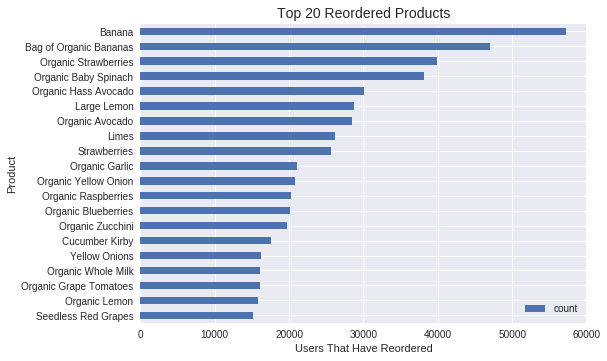

In [23]:
reorder_prods = orprod[orprod['reordered'] == 1].drop(['add_to_cart_order','reordered'], axis=1)
reorders = orders[orders['eval_set'] != 'test'].merge(reorder_prods[['order_id', 'product_id']], how='right', on=['order_id'])
reorders = reorders.merge(products[['product_id', 'product_name', 'department_id']], how='left', on=['product_id'])\
            .drop(['eval_set','order_dow','order_hour_of_day','days_since_prior_order'], axis=1)

reorders.drop_duplicates(subset=['user_id', 'product_id']).groupby(['product_name'])['user_id'].agg(['count']).sort_values(by='count',ascending=False)[:20].sort_values(by='count').plot(kind='barh')
plt.title('Top 20 Reordered Products', fontsize=14)
plt.ylabel('Product')
plt.xlabel('Users That Have Reordered')
plt.show()

The list and ranks of top reordered products are similar, but not identical to the top selling products.

## Top reordered products (exclusive of produce and dairy/eggs)

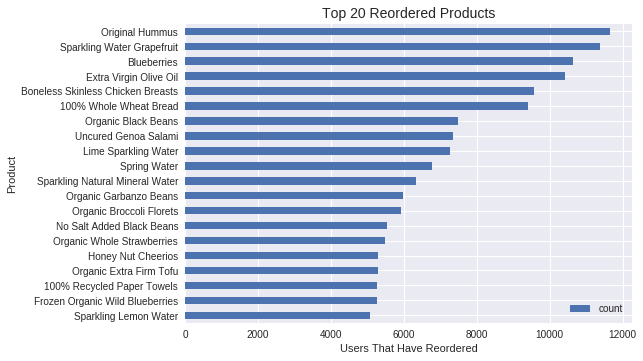

In [24]:
reorders = reorders[~reorders['department_id'].isin([4,16])]
reorders.drop_duplicates(subset=['user_id','product_id']).groupby(['product_name'])['user_id'].agg(['count']).sort_values(by='count',ascending=False)[:20].sort_values(by='count').plot(kind='barh')
plt.title('Top 20 Reordered Products', fontsize=14)
plt.ylabel('Product')
plt.xlabel('Users That Have Reordered')
plt.show()

Produce items listed here are frozen

## Top products volume by day of week

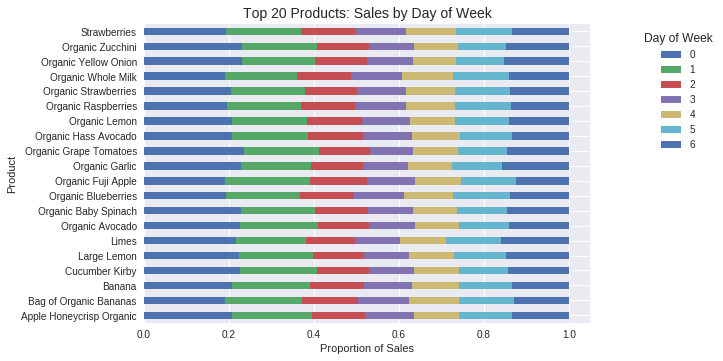

In [25]:
top_orprod = orprod[orprod['product_id'].isin(top_prod[:20].product_id.values)]

top_orprod_dow = top_orprod.merge(orders[['order_id','order_dow']], how='left', on=['order_id'])
top_orprod_dow = top_orprod_dow.groupby(['order_dow','product_id'])['product_id'].size().reset_index(name='count')
top_orprod_dow = top_orprod_dow.merge(products[['product_id', 'product_name']], how='left', on=['product_id']).drop(['product_id'], axis=1)

dow_prod_sales=top_orprod_dow.pivot(index='product_name', columns='order_dow',values='count')
totals = dow_prod_sales.sum(axis=1)

for c in dow_prod_sales.columns.values:
    dow_prod_sales[c] = dow_prod_sales[c]/totals
    
dow_prod_sales.plot.barh(stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1.1,1), title='Day of Week')
plt.title('Top 20 Products: Sales by Day of Week', fontsize=14)
plt.xlabel('Proportion of Sales')
plt.ylabel('Product')
plt.show()    

Top selling products have relatively consistent selling patterns over the week

## Top of mind items

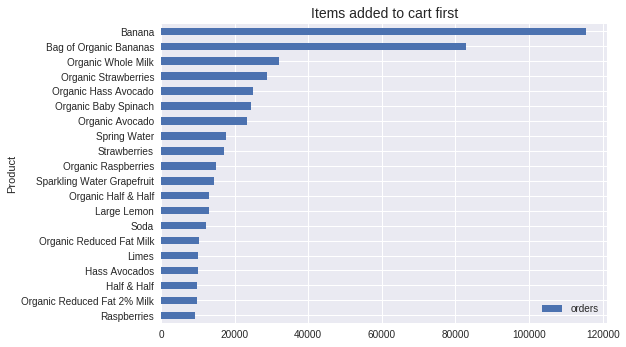

In [26]:
first_prod = orprod[orprod['add_to_cart_order'] == 1]\
    .groupby(['product_id'])['product_id'].agg(['count']).reset_index()\
    .sort_values(by='count', ascending=False)[:20]

first_prod = first_prod.merge(products[['product_id', 'product_name']], how='left', on=['product_id']).rename(columns={'count':'orders'})
first_prod.sort_values(by='orders').plot(kind='barh', x='product_name', y='orders')

plt.title('Items added to cart first', fontsize=14)
plt.ylabel('Product')
plt.xlabel('')
plt.show()

Bananas, of course

## Top products ordered together

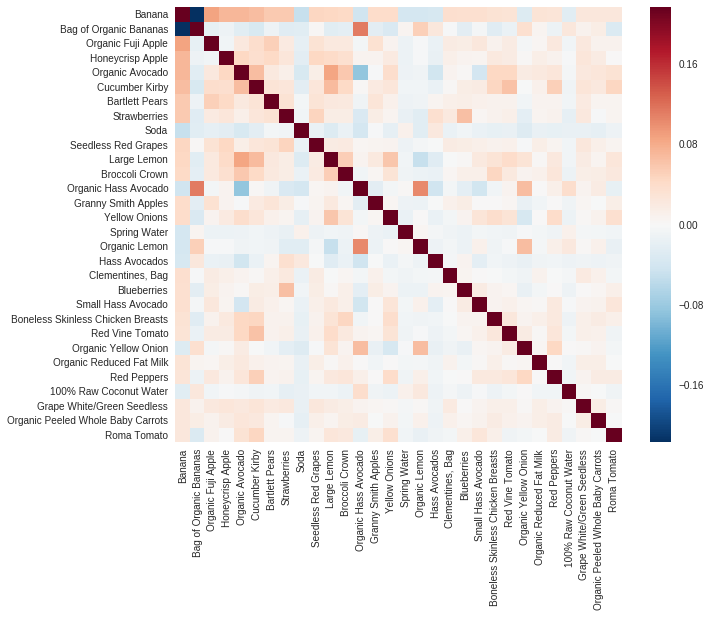

In [27]:
top_n_prod = top_prod[:100].drop(['count'], axis=1)
top_n_orprod = orprod[orprod['product_id'].isin(top_n_prod.product_id.values)].drop(['add_to_cart_order', 'reordered'], axis=1)
top_n_orprod = top_n_orprod.merge(products[['product_id', 'product_name']], how='left', on=['product_id']).drop(['product_id'], axis=1)

top_n_orprod['ordered'] = 1
orders_top_products = top_n_orprod.pivot(index='order_id', columns='product_name', values='ordered').fillna(value=0)

topcor = orders_top_products.corr().abs().nlargest(30, 'Banana').index
corr_matrix = np.corrcoef(orders_top_products[topcor].values.T)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, yticklabels=topcor.values, xticklabels=topcor.values, vmax=0.2)
plt.show()

There are some correlations, positive and negative, but most are relatively weak

## Most popular departments and aisles

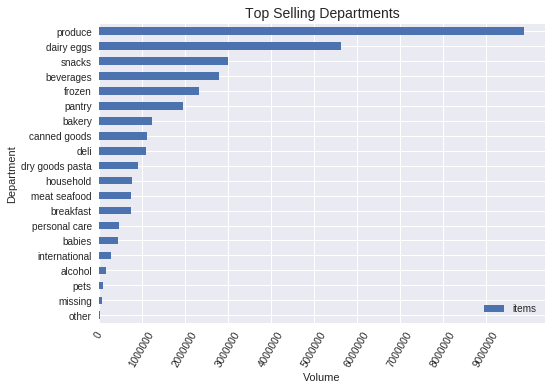

In [28]:
prod_dept_aisle = orprod.merge(products[['product_id', 'aisle_id', 'department_id']], how='left', on=['product_id'])
top_dept = prod_dept_aisle.groupby(['department_id'])['product_id'].aggregate(['count']).reset_index()
top_dept = top_dept.merge(departments, how='left', on=['department_id'] ).sort_values(by='count', ascending=False)[:20]

top_dept.sort_values(by='count').rename(columns={'count':'items'}).plot(kind='barh', x='department', y='items')
plt.xticks(range(0,10000000,1000000), rotation=60)
plt.title('Top Selling Departments', fontsize=14)
plt.ylabel('Department')
plt.xlabel('Volume')
plt.legend(loc='lower right')
plt.show()

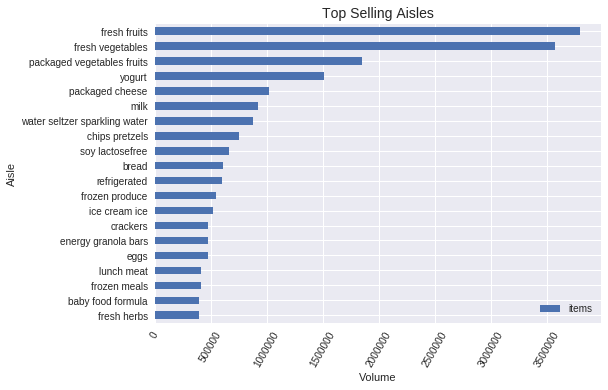

In [29]:
top_aisle = prod_dept_aisle.groupby(['aisle_id'])['product_id'].aggregate(['count']).reset_index()
top_aisle = top_aisle.merge(aisles, how='left', on=['aisle_id'] ).sort_values(by='count', ascending=False)[:20]

top_aisle.sort_values(by='count').rename(columns={'count':'items'}).plot(kind='barh', x='aisle', y='items')
plt.xticks(range(0,4000000,500000), rotation=60)
plt.title('Top Selling Aisles', fontsize=14)
plt.ylabel('Aisle')
plt.xlabel('Volume')
plt.show()